In [1]:
# default_exp nbeats.model_multi

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats model multi

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [4]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [12]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.layers import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *
from fastseq.nbeats.model import *

In [13]:
# export
# TODO
def make_base_rnn(u_in, layers, use_bn, ps):
    pass

In [94]:
# export
class DependentModel(object):
    """Returns the result of polynominal function on the dependent variable."""
    def __init__(self, norm=True):
        self.norm = norm
        
    def __call__(self, thetas, t, *args):
        p = thetas.size()[-1]
        t = (t - t.mean())/t.std()
        thetas = thetas.flatten()
        assert p < 6, f"thetas_dim is too big. p = {p}"        
        S = [(t*thetas[i]**i)[None,:] for i in range(p)]
        o = torch.cat(S).sum(0)
        return o

In [23]:
# export
class DependentBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, season = None,
            bn_final=False, ps:L=None, share_thetas=True, y_range=[-.5,.5], att=True, scale_exp = 4, stand_alone=False, base = None, **kwargs
    ):
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas,att,stand_alone,base" )
        half_dim =self.thetas_dim//2 if self.thetas_dim%2 == 0 else self.thetas_dim//2+1
        s = 1*scale_exp**-(torch.arange(float(half_dim))).to(self.device)
        if self.thetas_dim %2 == 0:
            self.scale = torch.cat([s,s])
        else:
            self.scale = torch.cat([s,s[:-1]])
        season = ifnone(season, self.horizon)
        super().__init__(DependentModel())
        self.to(device)

    def forward(self, x, t):
        if self.stand_alone:
            dct = super().forward(x[:,0,:], t[self.lookback:], t[:self.lookback])
            return torch.cat([dct['b'][:,None,:], dct['f'][:,None,:]],dim=-1)
        else:
            return super().forward(x, t[self.lookback:], t[:self.lookback])

In [24]:
show_doc(DependentModel)

<h2 id="DependentModel" class="doc_header"><code>class</code> <code>DependentModel</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>DependentModel</code>()

Returns the result of polynominal function on the dependent variable.

Text(0.5, 1.0, 'thetas:tensor([[1., 1., 1., 1.]])')

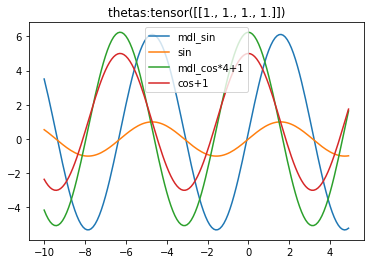

In [101]:
start, end = -10, 5.
theta = (torch.ones(4, device='cuda:0'))[None,:]
fnc = DependentModel()

t = torch.arange(start, end,.1, device='cuda:0')
dep = torch.sin(t)
plt.plot(t.cpu(),fnc(theta,dep).cpu().T, label = 'mdl_sin')
plt.plot(t.cpu(),dep.cpu().T, label = 'sin')


dep = torch.cos(t)*4+1
plt.plot(t.cpu(),fnc(theta,dep).cpu().T, label = 'mdl_cos*4+1')
plt.plot(t.cpu(),dep.cpu().T, label = 'cos+1')
plt.legend()
plt.title(f"thetas:{theta.data.cpu()}")

Text(0.5, 1.0, 'thetas:tensor([[0.6488, 0.8537, 0.0679, 0.6742]])')

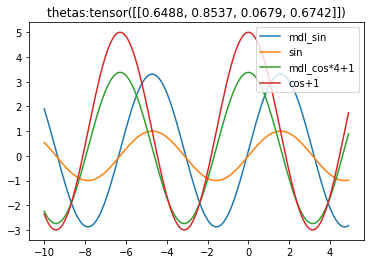

In [103]:
start, end = -10, 5.
theta = (torch.rand(4, device='cuda:0'))[None,:]

fnc = DependentModel()

t = torch.arange(start, end,.1, device='cuda:0')
dep = torch.sin(t)
plt.plot(t.cpu(),fnc(theta,dep).cpu().T, label = 'mdl_sin')
plt.plot(t.cpu(),dep.cpu().T, label = 'sin')


dep = torch.cos(t)*4+1
plt.plot(t.cpu(),fnc(theta,dep).cpu().T, label = 'mdl_cos*4+1')
plt.plot(t.cpu(),dep.cpu().T, label = 'cos+1')
plt.legend()
plt.title(f"thetas:{theta.data.cpu()}")

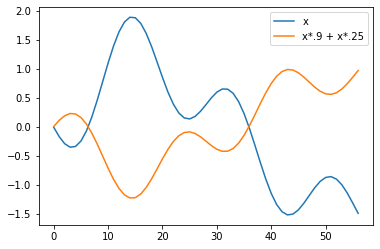

In [132]:
horizon, lookback = 7,25
items = dummy_data_generator(50, 7, nrows=10, norm=True, noise=0)[0]
pred_items = [(o-o.mean())*-.9+(o-o.mean())*.5**2 for o in items]
plt.plot(items[0],label = 'x')
plt.plot(pred_items[0],label='x*.9 + x*.25')
plt.legend()

(1, 57)
Train:20; Valid: 10; Test 10


epoch,train_loss,valid_loss,time
0,1.836597,0.953059,00:00
1,1.582208,0.779090,00:00
2,1.412000,0.688815,00:00
3,1.295696,0.648734,00:00
4,1.209056,0.644706,00:00
5,1.144077,0.643784,00:00
6,1.089790,0.642580,00:00
7,1.046075,0.646494,00:00
8,1.010288,0.647919,00:00
9,0.980348,0.639831,00:00


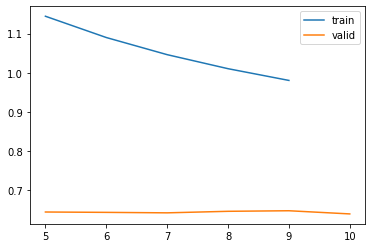

In [ ]:
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=5, after_batch = NormalizeTS(), valid_pct=.5, bs = 32)
                                
mdl = DependentBlock([256,256], thetas_dim=10, device = data.train.device, horizon=horizon, lookback=lookback,stand_alone=True, season = lookback+horizon)
learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func= Adam,)                  

learn.fit(10, .01)
learn.recorder.plot_loss()     

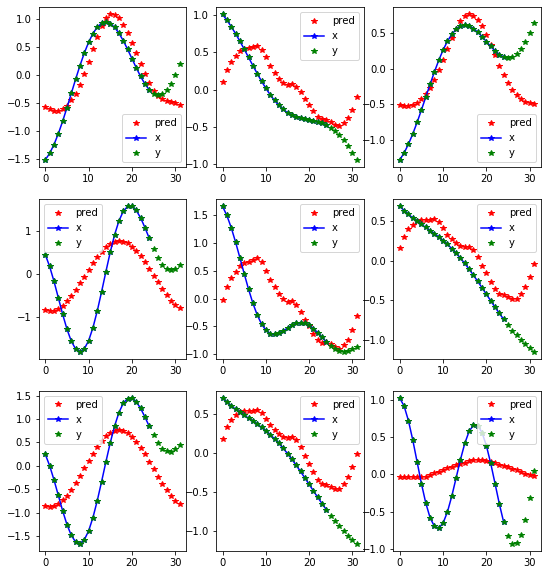

In [ ]:
learn.show_results()

In [ ]:
# hide
mdl = SeasonalityBlock([256], thetas_dim=3, device=device, lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(device))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['attention'].shape, (64,3))


mdl = SeasonalityBlock([256], thetas_dim=4, device=device, lookback=100, horizon=10, stand_alone=True)
bf = mdl(torch.randn(64,1,100).to(device))
test_eq(bf.shape, (64,1,110))

In [ ]:
# export

# not pritty but still works better
def _select_block(o):
    if isinstance(o,int):
        if o == 0:
            return SeasonalityBlock
        elif o == 1:
            return TrendBlock
        elif o == 2:
            return BaisBlock
        else:
            return GenericBlock
    else:
        if o == 'seasonality':
            return SeasonalityBlock
        elif o == 'trend':
            return TrendBlock
        elif o =='bias':
            return BiasBlock
        else:
            return GenericBlock

default_thetas={'seasonality':6,'trend':4,'bais':2}

In [133]:
# export
class NBeatsMNet(Module):
    def __init__(
        self,
        device,
        stack_types=('trend', 'seasonality'),
        nb_blocks_per_stack=3,
        horizon=5,
        lookback=10,
        thetas_dim=None,
        share_weights_in_layers=True,
        layers= [1024,512],
        norm=False,
        **kwargs,
    ):
        thetas_dim = ifnone(thetas_dim,[default_thetas[o] for o in L(stack_types)])
        stack_types= L(stack_types)
        self.eps, self.m, self.s = Variable(tensor(1e-7), requires_grad=False).to(device),Variable(tensor(1e-7), requires_grad=True).to(device),Variable(tensor(1e-7), requires_grad=True).to(device)
        store_attr(self,'device,horizon,lookback,layers,nb_blocks_per_stack,share_weights_in_layers,stack_types,thetas_dim,device,norm,kwargs')
        self.stacks = []
        self._str = "| N-Beats\n"

        self.bn = BatchNorm(lookback, ndim=2)
        stacks = OrderedDict()
        self.base = None
        if self.share_weights_in_layers:
            self.base = make_base(self.lookback, self.layers, True, None)
        for stack_id in range(len(self.stack_types)):
            stacks[str(self.stack_types[stack_id]) + str(stack_id)] = self.create_stack(stack_id)
        self.stacks = nn.Sequential(stacks)

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        self._str += f"| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_layers})\n"

        blocks = []
        for thetas_dim in range(3,self.thetas_dim[stack_id]+1):
            block_init = _select_block(stack_type)
            block = block_init(
                layers = self.layers,
                thetas_dim = thetas_dim,
                device = self.device,
                lookback = self.lookback,
                horizon = self.horizon,
                base = self.base,
                **self.kwargs
                )
            self._str += f"     | -- {block}\n"
            blocks.append(block)

        return nn.Sequential(*blocks)

    def iter_blocks(self):
        for stack_id, names in enumerate(self.stacks.named_children()):
            name = names[0]
            for block_id in range(len(self.stacks[stack_id])):
                yield name, stack_id, block_id, self.stacks[stack_id][block_id]

    def forward(self, x):
        self.dct = None
        if self.norm:
            self.m, self.s = torch.mean(x,-1,keepdim=True), x.std(-1,keepdim=True) + self.eps
            x = (x-self.m)/self.s
            print('requires_grad',x.requires_grad)
        backcast_res = x.view([-1,x.shape[-1]])
        backcast = torch.zeros(
            size=(backcast_res.size()[0], self.lookback,)
        )
        forecast = torch.zeros(
            size=(backcast.size()[0], self.horizon,)
        )  # maybe batch size here.

        dct = defaultdict(dict)
        for stack_id, names in enumerate(self.stacks.named_children()):
            name = names[0]
            for block_id in range(len(self.stacks[stack_id])):
                _dct = self.stacks[stack_id][block_id](backcast_res)
                backcast_res = backcast_res.to(self.device) - _dct['b']

                backcast = backcast.to(self.device) + _dct['b']
                forecast = forecast.to(self.device) + _dct['f']
                _dct['_full'] = torch.cat([_dct['b'] , _dct['f']], dim=-1)
                dct[name+'_'+str(block_id)] = _dct

        dct['f'] = forecast[:,None,:]
        dct['b'] = backcast[:,None,:]
        self.dct = dct
        res = torch.cat([backcast[:,None,:], forecast[:,None,:]], dim=-1)
        if self.norm:
            return (res*self.s)+self.m
        return res

    def __setattr__(self, key, value):
        if key in ['lookback','horizon']:
            if hasattr(self,'stacks'):
                for name, stack_id, block_id, stack in self.iter_blocks():
                    setattr(stack, key, value)
        super().__setattr__(key, value)

In [134]:
show_doc(select_block, name='select_block')

<h4 id="select_block" class="doc_header"><code>select_block</code><a href="https://github.com/takotab/fastseq/tree/master/fastseq/nbeats/model.py#L186" class="source_link" style="float:right">[source]</a></h4>

> <code>select_block</code>(**`o`**)



In [138]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 05_nbeats.models_multi.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
